Importing necessary libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import importlib


Function created to install appropriate libraries to if it is not already present

In [53]:
def install_library_if_not_present(library_name):
  try:
    importlib.import_module(library_name)
    print(f'{library_name} is already installed.')
  except ImportError:
    print(f'{library_name} is not installed. Installing now...')
    try:
      import pip
      pip.main(['install', library_name])
      print(f'{library_name} installed successfully!')
    except Exception as e:
      print(f'Error installing {library_name}: {e}')

Download 'amazon-product-reviews' dataset from kaggle

In [54]:
if 'amazon-product-reviews' not in os.listdir():
  install_library_if_not_present('opendatasets')
  import opendatasets as od
  od.download('https://www.kaggle.com/datasets/irvifa/amazon-product-reviews')

Load the datsset as dataframe with column names using pandas

In [55]:
df = pd.read_csv('/content/amazon-product-reviews/ratings_Electronics.csv', names =['userId', 'productId', 'rating', 'timestamp'])

In [56]:
df.shape

(7824482, 4)

Taking 30% of data since it is difficult to analyze whole dataset

In [57]:
electronics_df = df.sample(n = int(df.shape[0]*0.5), ignore_index = True)

Deleting original dataset to release memory

In [58]:
del df

In [59]:
electronics_df.head()

,userId,productId,rating,timestamp
0,A3EKOHO62Z6X2J,B00BCPIFC2,2.0,1373068800
1,A2TC2PWSW0Z0LF,B002YU83YO,1.0,1378598400
2,A1R3ELNRS6FEGN,B0040IO1RQ,1.0,1315353600
3,A1AC0ZLC6SVXSD,B009LVPYDM,5.0,1368057600
4,A3DQLTL8XIE1TZ,B000IBNXVY,4.0,1184544000


Dataset informations

In [60]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912241 entries, 0 to 3912240
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 119.4+ MB


Check if there is null values

In [61]:
electronics_df.isna().sum()

,0
userId,0
productId,0
rating,0
timestamp,0


Feature Engineering : Deleteing timestamp column (Not necessary for prediction)

In [62]:
electronics_df = electronics_df.drop('timestamp', axis = 1)

In [63]:
electronics_df.describe()

,rating
count,3.912241e+06
mean,4.011494e+00
std,1.381491e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


Rating ranges from 1 to 5 and average is around 4

In [64]:
electronics_df[electronics_df.duplicated()].shape[0]

0

#Visualizing Rating distribution

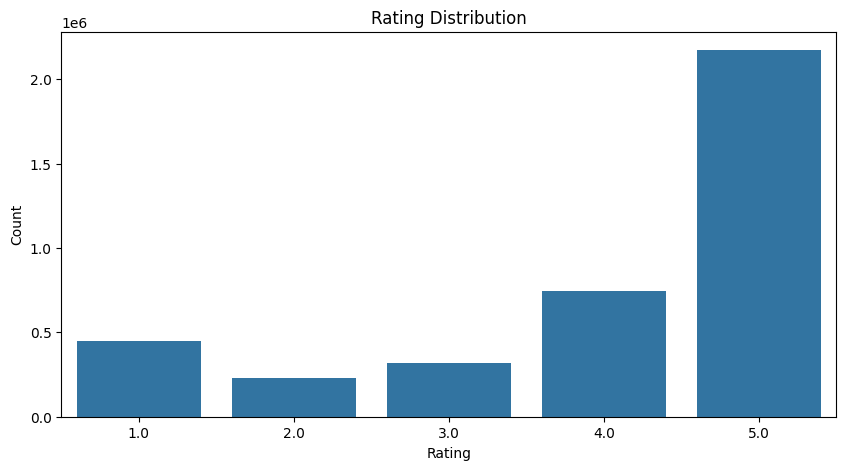

In [65]:
plt.figure(figsize = (10, 5))
sns.countplot(x = 'rating', data = electronics_df)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Finding out total number of ratings, unique users and unique products

In [66]:
print("Total rating : ", electronics_df.shape[0])
print("Total unique users : ", electronics_df['userId'].unique().shape[0])
print("Total unique products : ", electronics_df['productId'].unique().shape[0])

Total rating :  3912241
Total unique users :  2548986
Total unique products :  360707


Analyzing ratings of users

In [67]:
rated_products_per_user = electronics_df.groupby('userId')['rating'].count().sort_values(ascending = False)
rated_products_per_user.head()

,rating
userId,
A5JLAU2ARJ0BO,275
ADLVFFE4VBT8,264
A3OXHLG6DIBRW8,231
A6FIAB28IS79,228
A680RUE1FDO8B,226


In [68]:
print("Number of users who have rated more than 50 products : {}".format(rated_products_per_user[rated_products_per_user >= 50].shape[0]))

Number of users who have rated more than 50 products : 303


#Popularity based Recommendation

In [69]:
data = electronics_df.groupby('productId').filter(lambda x: x['rating'].count() >= 50)

In [70]:
data.head()

,userId,productId,rating
0,A3EKOHO62Z6X2J,B00BCPIFC2,2.0
1,A2TC2PWSW0Z0LF,B002YU83YO,1.0
2,A1R3ELNRS6FEGN,B0040IO1RQ,1.0
3,A1AC0ZLC6SVXSD,B009LVPYDM,5.0
5,A1L7K77UO3KH06,B004I4YOUG,4.0


In [71]:
no_of_rating_per_products = data.groupby('productId')['rating'].count().sort_values(ascending = False)
no_of_rating_per_products.head()

,rating
productId,
B0074BW614,9088
B00DR0PDNE,8090
B007WTAJTO,6994
B0019EHU8G,6037
B006GWO5WK,6024


Ploting top 20 products

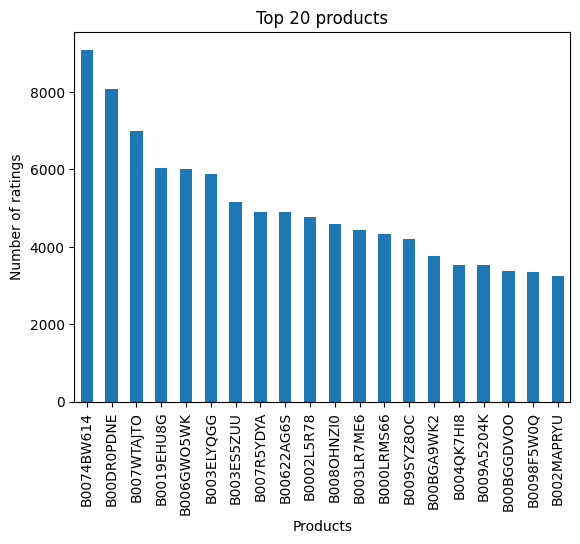

In [72]:
no_of_rating_per_products.head(20).plot(kind = 'bar')
plt.xlabel('Products')
plt.ylabel('Number of ratings')
plt.title('Top 20 products')
plt.show()

Calculating average rating per product

In [73]:
mean_rating_product_count = pd.DataFrame(data.groupby('productId')['rating'].mean())

In [74]:
mean_rating_product_count.head()

,rating
productId,
0972683275,4.443810
1400501466,3.356643
1400501776,4.090909
1400532620,3.613636
1400532655,3.764000


Plotting distribution of average rating products

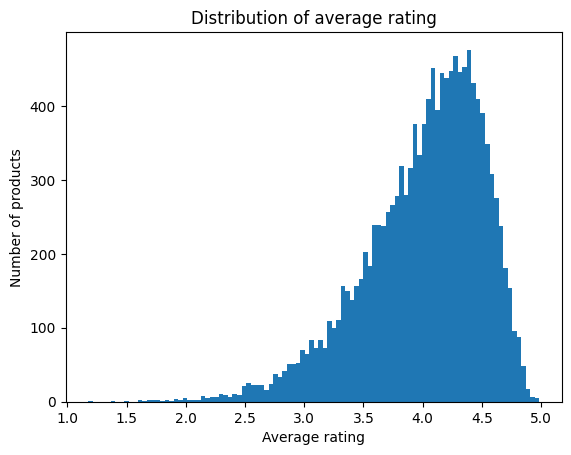

In [75]:
plt.hist(mean_rating_product_count['rating'], bins = 100)
plt.xlabel('Average rating')
plt.ylabel('Number of products')
plt.title('Distribution of average rating')
plt.show()

Measure the skewness of the distribution. Skewness quantifies the asymmetry of a distribution around its mean.

Skewness = 0 → Perfectly symmetrical distribution (Normal Distribution).

Skewness > 0 → Right-skewed (positively skewed): More values are concentrated on the left.

Skewness < 0 → Left-skewed (negatively skewed): More values are concentrated on the right.

In [76]:
mean_rating_product_count['rating'].skew()

-0.9508787728783761

Hence it is Left-skewed

Adding new column rating count to data frame

In [77]:
mean_rating_product_count['rating_counts'] = pd.DataFrame(data.groupby('productId')['rating'].count())

In [78]:
mean_rating_product_count.head()

,rating,rating_counts
productId,,
0972683275,4.443810,525
1400501466,3.356643,143
1400501776,4.090909,66
1400532620,3.613636,88
1400532655,3.764000,250


Highest and lowest mean rating products

In [79]:
mean_rating_product_count[mean_rating_product_count['rating_counts'] == mean_rating_product_count['rating_counts'].max()]

,rating,rating_counts
productId,,
B0074BW614,4.492958,9088


In [80]:
print('Maximum average rating products : ', mean_rating_product_count['rating_counts'].max())
print('Minimum average rating products : ', mean_rating_product_count['rating_counts'].min())
print('Total Minimum average rating products : ', mean_rating_product_count[mean_rating_product_count['rating_counts'] == mean_rating_product_count['rating_counts'].min()].shape[0])

Maximum average rating products :  9088
Minimum average rating products :  50
Total Minimum average rating products :  281


Plotting rating count of mean_rating_product_count

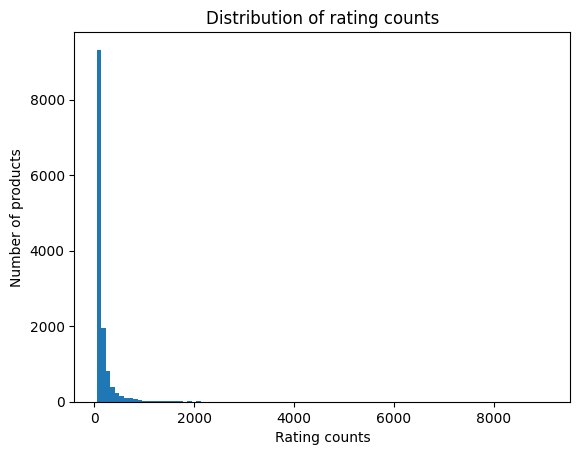

In [81]:
plt.hist(mean_rating_product_count['rating_counts'], bins = 100)
plt.xlabel('Rating counts')
plt.ylabel('Number of products')
plt.title('Distribution of rating counts')
plt.show()

Joint plot for rating and rating count

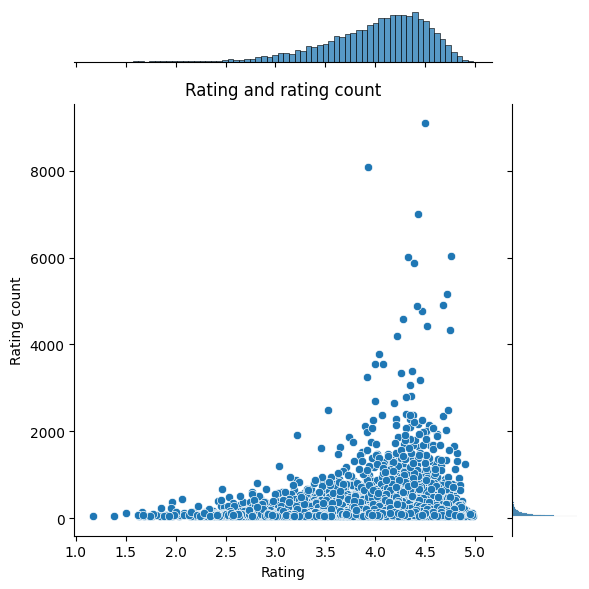

In [82]:
sns.jointplot(x = 'rating', y = 'rating_counts', data = mean_rating_product_count)
plt.title('Rating and rating count')
plt.xlabel('Rating')
plt.ylabel('Rating count')
plt.tight_layout()
plt.show()

Corelation between Rating and Rating count

In [83]:
print('Corelation between Rating and Rating count is : ', mean_rating_product_count['rating'].corr(mean_rating_product_count['rating_counts']))

Corelation between Rating and Rating count is :  0.08807073099501352


#Collaberative filtering

Importing surprise library for collaberative filtering

In [84]:
install_library_if_not_present('surprise')
from surprise import KNNWithMeans, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split

surprise is already installed.


Reading the dataset

In [85]:
reader = Reader(rating_scale = (1, 5))
surprise_data = Dataset.load_from_df(data, reader)

Splitting to training and testing datasets

In [86]:
trainset, testset = train_test_split(surprise_data, test_size = 0.2, random_state = 42)

Can use user_based or item_based collaberative filtering by selecting true or false in user_based parameter

In [87]:
model_knn = KNNWithMeans(k = 5, sim_options = {'name': 'pearson_baseline', 'user_based': False})
model_knn.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Predictions using testset

In [88]:
test_pred = model_knn.test(testset)

In [89]:
print("Item-based KNN model : Test set")
accuracy.rmse(test_pred, verbose = True)

Item-based KNN model : Test set
RMSE: 1.3245


1.324474281779862

Model-based collaberative filtering

In [90]:
data2 = data.sample(20000)
rating_matrix = data2.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)

In [91]:
rating_matrix.head()

productId,0972683275,1400532620,1400532655,1400599997,9573212919,9983891212,B000001OM5,B000001ON6,B00000DM9W,B00000J061,...,B00J5174TU,B00J5HDEPC,B00J5O7BMC,B00JDAIMQ2,B00JEGLLEA,B00JP12170,B00K0OBEE2,B00K4VQZCM,B00K589F8A,B00K91DB7Y
userId,,,,,,,,,,,,,,,,,,,,,
A00229242RO5Y0ANY7P7H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0056746VLX0I5VJCFN6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01112834ODK5R6L1MGU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0173694V912CIFGWYM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01741122WEVIHH0GTQTS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Shape of rating_matrix

In [92]:
rating_matrix.shape

(19884, 8186)

Transpose the metrix to make column (productId) as index and index as column (userId)

In [93]:
x_ratings_matrix = rating_matrix.T
x_ratings_matrix.head()

userId,A00229242RO5Y0ANY7P7H,A0056746VLX0I5VJCFN6,A01112834ODK5R6L1MGU,A0173694V912CIFGWYM,A01741122WEVIHH0GTQTS,A02114691JJZ1YWGBQ7Y7,A02605471TE80EMT2SJQX,A027717628HVUA4XE5VL3,A03053323YNCXMBZ039N,A03225661V9CQJL586YDM,...,AZXVT7BZOQM3V,AZXX2IV3T43M2,AZXXSOF328C52,AZY5WADV3UWQU,AZY6S09JQF8UK,AZYJE40XW6MFG,AZYYK3M5TO7E0,AZZ4K7ROUMSPG,AZZLZUR5X9GYE,AZZTG7HZLP2XI
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400599997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9573212919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
x_ratings_matrix.shape

(8186, 19884)

Decomposition of the matrix using Singular Value Decomposition technique


In [95]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(x_ratings_matrix)
decomposed_matrix.shape

(8186, 10)

Correlation Matrix


In [96]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(8186, 8186)

In [97]:
x_ratings_matrix.index[10]

'B00000J1V5'

In [98]:
i=x_ratings_matrix.index[10]
product_names=list(x_ratings_matrix.index)
product_id=product_names.index(i)
print(product_id)

10


Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [99]:
correlation_product_ID = correlation_matrix[product_id]
correlation_product_ID.shape

(8186,)

In [100]:
correlation_matrix[correlation_product_ID>0.75].shape

(907, 8186)

#Recommending top 20 highly correlated products in sequence

In [101]:
recommend = list(x_ratings_matrix.index[correlation_product_ID > 0.75])
recommend[:20]

['9983891212',
 'B000001ON6',
 'B00000J1V5',
 'B00000K13A',
 'B00001P4ZR',
 'B00001P505',
 'B00002NDRQ',
 'B00004SABB',
 'B00004SY4H',
 'B00004T1XK',
 'B00004THCZ',
 'B00004VUGJ',
 'B00004WCGC',
 'B00004X0ZO',
 'B00004Z0C7',
 'B00005BC0K',
 'B00005Q5U5',
 'B00005T3N3',
 'B00005TQ08',
 'B0000633EO']